In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, optimizers, Input, optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time
import os
from time import sleep
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import pprint
import pywt
tf.__version__

'2.8.0'

In [2]:
%load_ext tensorboard

In [3]:
start = time.perf_counter()

In [4]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [5]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


### Create Log directories for Tensorboard

In [6]:
try:
    if not os.path.exists("logs"):
        log_path = os.path.join("logs","fit")
        os.makedirs(os.path.join(log_path,"lstm","bidirectional"))
        os.mkdir(os.path.join(log_path,"cnn"))
        print("log files are created")
    else:
        print("log files already exist")
except Exception as e:
    print(e)
    print("Error while creating log directories. Aborted.")

log files are created


In [ ]:
image_path = "images"
try:
    os.mkdir(image_path)
    
except Exception as e:
    print(e)
    print("Error while creating image directory. Aborted.")


In [7]:
X_x_train = np.loadtxt("./data/X_x_train.txt")
X_y_train = np.loadtxt("./data/X_y_train.txt")
X_z_train = np.loadtxt("./data/X_z_train.txt")
y_train = np.loadtxt("./data/y_train.txt")

X_x_test = np.loadtxt("./data/X_x_test.txt")
X_y_test = np.loadtxt("./data/X_y_test.txt")
X_z_test = np.loadtxt("./data/X_z_test.txt")
y_test = np.loadtxt("./data/y_test.txt")

In [9]:
def standard_score_normalization(x):
    x_m = np.mean(x, axis=1).reshape(-1,1)
    x_std = np.std(x,axis=1).reshape(-1,1)
    return (x-x_m)/x_std

In [10]:
norm = StandardScaler()

In [11]:
X_x_train_norm = norm.fit_transform(X_x_train)
X_y_train_norm = norm.fit_transform(X_y_train)
X_z_train_norm = norm.fit_transform(X_z_train)

X_x_test_norm = norm.fit_transform(X_x_test)
X_y_test_norm = norm.fit_transform(X_y_test)
X_z_test_norm = norm.fit_transform(X_z_test)

### Below I'm testing two different concatenation functions for performance.

concat_xyz is vectorizing calculations while concat2_xyz is iterating

In [12]:
def concat_xyz(x,y,z):
    data = np.empty((x.shape[0],x.shape[1],3))
#     x = np.expand_dims(x, axis=1) # same as x = x[:,np.newaxis,:]
#     y = np.expand_dims(y, axis=1)
#     z = np.expand_dims(z, axis=1)
    data[:,:,0] = x
    data[:,:,1] = y
    data[:,:,2] = z
    return data

In [13]:
#speed test purposes
def concat2_xyz(x,y,z):
    data = np.empty((x.shape[0],x.shape[1],3))
    for i, rowx,rowy, rowz in zip(range(x.shape[0]),x,y,z):
        data[i,:,0] = rowx.reshape(1,-1)
        data[i,:,1] = rowy.reshape(1,-1)
        data[i,:,2] = rowz.reshape(1,-1)
    return data

In [14]:
tic = time.perf_counter()
X_xyz_norm_train =  concat_xyz(X_x_train_norm,X_y_train_norm, X_z_train_norm)
X_xyz_norm_test = concat_xyz(X_x_test_norm,X_y_test_norm,X_z_test_norm)
toc = time.perf_counter()
print(f"concat_xyz in {toc - tic:0.4f} seconds")

concat_xyz in 0.0073 seconds


In [15]:
#speed test purposes
tic = time.perf_counter()
concat2_xyz(X_x_train_norm,X_y_train_norm, X_z_train_norm)
concat_xyz(X_x_test_norm,X_y_test_norm,X_z_test_norm)
toc = time.perf_counter()
print(f"concat2_xyz in {toc - tic:0.4f} seconds")

concat2_xyz in 0.0152 seconds


Vectorizing calculations improves performance from original github notebook linked in README

In [16]:
label_names = ['Walking', 'Walking upstairs', 'Walking downstairs', 'Sitting', 'Standing', 'Laying']
num_classes = len(label_names)

First I tried this model with one hot encoded y values with catagorical cross entropy but for the confusion matrix I needed the multiclass values instead so during my second iteration I reformatted the model and the data.

In [17]:
# shifting y_train to values from 0 to num_classes-1
y_train = y_train - 1
y_test = y_test - 1

In [18]:
# one hot encoding
y_ohe_train = to_categorical(y_train,num_classes)
y_ohe_test = to_categorical(y_test, num_classes)

In [19]:
X_xyz_norm_train.shape

(7352, 128, 3)

In [20]:
X_xyz_norm_test.shape

(2947, 128, 3)

In [21]:
y_train.shape

(7352,)

In [22]:
y_test.shape

(2947,)

In [23]:
y_ohe_train.shape

(7352, 6)

In [24]:
input_shape = X_xyz_norm_train.shape[1:]

In TF1, placeholder would be needed to get input shape of `(None, 128, 3)` but here we take `(128, 3)` as input shape instead

# Creating Continuous Wavelet Transforms representing time series data

In [25]:
X_xyz_norm_train_swap = np.swapaxes(X_xyz_norm_train,1,2)

In [26]:
X_xyz_norm_train.shape

(7352, 128, 3)

In [27]:
X_xyz_norm_train_swap.shape

(7352, 3, 128)

### Showing the 1/7352 128-sample run

In [2]:
plt.title("Normalized Accelerometer Data for 1/7352 Runs")
plt.plot(X_xyz_norm_train_swap[0][0])
plt.plot(X_xyz_norm_train_swap[0][1])
plt.plot(X_xyz_norm_train_swap[0][2])
plt.savefig(os.path.join(image_path,
plt.show

SyntaxError: '(' was never closed (1561152710.py, line 5)

In [29]:
signal = np.sqrt((X_xyz_norm_train_swap[0][0])**2+(X_xyz_norm_train_swap[0][1])**2+(X_xyz_norm_train_swap[0][2])**2)

<function matplotlib.pyplot.show(close=None, block=None)>

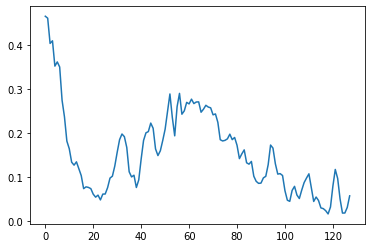

In [30]:
plt.plot(signal)
plt.show

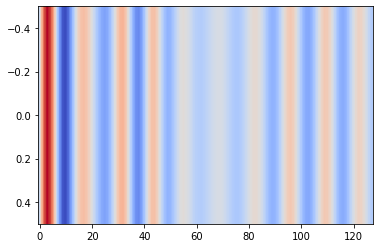

In [31]:
# samples taken at 50hz
coeffs, freqs = pywt.cwt(signal,10,'morl')
plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')

Using Morlet wavelets

<H1>Implementing CNN</H1>

In [32]:
cnn = models.Sequential()
cnn.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
# cnn.add(layers.MaxPool1D(pool_size=2))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(100, activation='relu'))
cnn.add(layers.Dense(30, activation='relu'))
cnn.add(layers.Dense(num_classes,activation='softmax'))

In [33]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 127, 64)           448       
                                                                 
 flatten (Flatten)           (None, 8128)              0         
                                                                 
 dense (Dense)               (None, 100)               812900    
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 6)                 186       
                                                                 
Total params: 816,564
Trainable params: 816,564
Non-trainable params: 0
_________________________________________________________________


In [34]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
cnn.compile(optimizer="adam",
           loss="categorical_crossentropy",
           metrics="accuracy")

### Creating Tensorboard Logs and running CNN model

In [35]:
log_dir = "logs/fit/cnn/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
cnn_tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
cnnhistory = cnn.fit(X_xyz_norm_train, y_ohe_train, epochs=50, batch_size = 10, validation_data=(X_xyz_norm_test, y_ohe_test),callbacks=[cnn_tensorboard_callback])

Epoch 1/50
736/736 [==============================] - 3s 2ms/step - loss: 0.9039 - accuracy: 0.5857 - val_loss: 0.7548 - val_accuracy: 0.6790
Epoch 2/50
736/736 [==============================] - 1s 2ms/step - loss: 0.5673 - accuracy: 0.7367 - val_loss: 0.7227 - val_accuracy: 0.7044
Epoch 3/50
736/736 [==============================] - 1s 2ms/step - loss: 0.4763 - accuracy: 0.7738 - val_loss: 0.7021 - val_accuracy: 0.7302
Epoch 4/50
736/736 [==============================] - 1s 2ms/step - loss: 0.4384 - accuracy: 0.7996 - val_loss: 0.7765 - val_accuracy: 0.7180
Epoch 5/50
736/736 [==============================] - 1s 2ms/step - loss: 0.3973 - accuracy: 0.8199 - val_loss: 0.6862 - val_accuracy: 0.7214
Epoch 6/50
736/736 [==============================] - 1s 2ms/step - loss: 0.3767 - accuracy: 0.8290 - val_loss: 0.6257 - val_accuracy: 0.7825
Epoch 7/50
736/736 [==============================] - 1s 2ms/step - loss: 0.3534 - accuracy: 0.8428 - val_loss: 0.8491 - val_accuracy: 0.7421
Epoch 

In [36]:
# %tensorboard --logdir logs/fit/cnn/

To run tensorboard in the cli use command ```tensorboard --logdir logs/fit/cnn/```

In [37]:
# cnn.save("my_model")
# tensorflow_graph = tf.saved_model.load("my_model")
# x = np.random.uniform(size=(4, 32)).astype(np.float32)
# predicted = tensorflow_graph(x).numpy()

In [38]:
# loss_values = cnnhistory.history['loss']
# epochs = range(1, len(loss_values)+1)

# plt.plot(epochs, loss_values, label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [39]:
# acc_values = cnnhistory.history['accuracy']
# epochs = range(1, len(loss_values)+1)

# plt.plot(epochs, acc_values, label='Training Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

[4 5 4 ... 1 1 1]
[4. 4. 4. ... 1. 1. 1.]


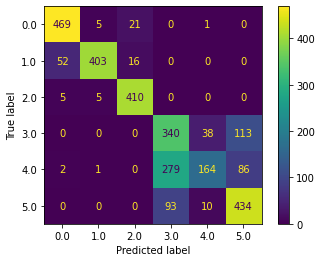

In [40]:
y_pred = np.argmax(cnn.predict(X_xyz_norm_test),axis=1)
print(y_pred)
# print(y_pred.shape)
# y_test_1D = np.argmax(y_test, axis=1).T[0]
# print(type(y_test_1D))
print(y_test)
# print(y_test_1D.shape)
conf = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
conf.plot()

<H1>Implementing LSTM</H1>

In [41]:
# LSTM
lstm = models.Sequential()
lstm.add(layers.LSTM(128,input_shape=input_shape))
lstm.add(layers.Dropout(rate=0.2))
lstm.add(layers.Dense(6,activation="softmax"))

In [42]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 68,358
Trainable params: 68,358
Non-trainable params: 0
_________________________________________________________________


In [43]:
lstm.compile(optimizer = "adam",
            loss="categorical_crossentropy",
            metrics = "accuracy"
            )

In [44]:
lstm_log_dir = "logs/fit/lstm/lstm" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
lstm_tensorboard_callback = TensorBoard(log_dir=lstm_log_dir, histogram_freq=1)

In [45]:
lstmhistory = lstm.fit(X_xyz_norm_train,y_ohe_train,epochs = 50,batch_size=10,validation_data=(X_xyz_norm_test, y_ohe_test),callbacks=[lstm_tensorboard_callback])

Epoch 1/50
736/736 [==============================] - 11s 11ms/step - loss: 1.2011 - accuracy: 0.4119 - val_loss: 0.8835 - val_accuracy: 0.5232
Epoch 2/50
736/736 [==============================] - 8s 10ms/step - loss: 0.8574 - accuracy: 0.5314 - val_loss: 1.2067 - val_accuracy: 0.4272
Epoch 3/50
736/736 [==============================] - 8s 11ms/step - loss: 0.7271 - accuracy: 0.5973 - val_loss: 0.8839 - val_accuracy: 0.5114
Epoch 4/50
736/736 [==============================] - 8s 11ms/step - loss: 0.6849 - accuracy: 0.6069 - val_loss: 0.7765 - val_accuracy: 0.6030
Epoch 5/50
736/736 [==============================] - 8s 10ms/step - loss: 0.6713 - accuracy: 0.6125 - val_loss: 0.6755 - val_accuracy: 0.6264
Epoch 6/50
736/736 [==============================] - 7s 10ms/step - loss: 0.7145 - accuracy: 0.6053 - val_loss: 0.6844 - val_accuracy: 0.6077
Epoch 7/50
736/736 [==============================] - 7s 9ms/step - loss: 0.6382 - accuracy: 0.6270 - val_loss: 0.6631 - val_accuracy: 0.6271

In [46]:
# %tensorboard --logdir logs/fit/lstm/

To run tensorboard in the cli use command ```tensorboard --logdir logs/fit/lstm/```

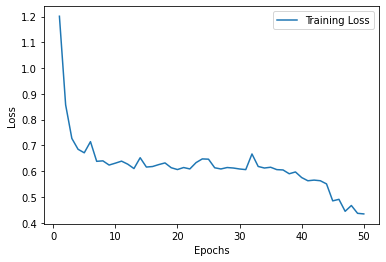

In [47]:
loss_values = lstmhistory.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

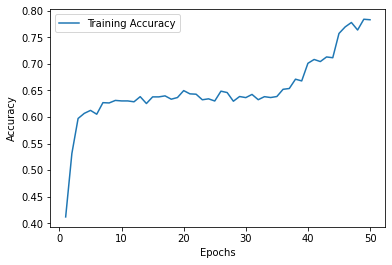

In [48]:
acc_values = lstmhistory.history['accuracy']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, acc_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

[4 4 4 ... 1 1 1]
[4. 4. 4. ... 1. 1. 1.]


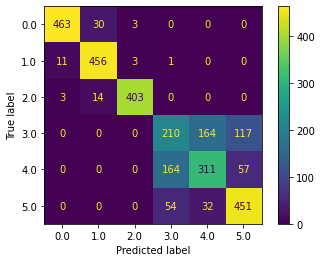

In [49]:
y_pred = np.argmax(lstm.predict(X_xyz_norm_test),axis=1)
print(y_pred)
# print(y_pred.shape)
# y_test_1D = np.argmax(y_test, axis=1).T[0]
# print(type(y_test_1D))
print(y_test)
# print(y_test_1D.shape)
conf = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
conf.plot()

In [50]:
# %tensorboard --logdir logs/fit/lstm/

To run tensorboard in the cli use command ```tensorboard --logdir logs/fit/lstm/```

<H1>Implementing Bidirectional LSTM</H1>

In [51]:
# Bidirectional LSTM

bidirectional_lstm = models.Sequential()
bidirectional_lstm.add(layers.Bidirectional(
    layers.LSTM(128),input_shape=input_shape
))
bidirectional_lstm.add(layers.Dropout(rate=0.2))
bidirectional_lstm.add(layers.Dense(6,activation="softmax"))

In [52]:
bidirectional_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              135168    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 136,710
Trainable params: 136,710
Non-trainable params: 0
_________________________________________________________________


In [53]:
bidirectional_lstm.compile(optimizer = "adam",
            loss="categorical_crossentropy",
            metrics = "accuracy"
            )

In [54]:
bidirectional_lstm_log_dir = "logs/fit/lstm/bidirectional" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
bidirectional_lstm_tensorboard_callback = TensorBoard(log_dir=lstm_log_dir, histogram_freq=1)

In [55]:
lstmhistory = lstm.fit(X_xyz_norm_train,y_ohe_train,epochs = 50,batch_size=10,validation_data=(X_xyz_norm_test, y_ohe_test),callbacks=[bidirectional_lstm_tensorboard_callback])

Epoch 1/50
736/736 [==============================] - 8s 10ms/step - loss: 0.4234 - accuracy: 0.7878 - val_loss: 0.6021 - val_accuracy: 0.7465
Epoch 2/50
736/736 [==============================] - 8s 11ms/step - loss: 0.4064 - accuracy: 0.8017 - val_loss: 0.5050 - val_accuracy: 0.7686
Epoch 3/50
736/736 [==============================] - 8s 10ms/step - loss: 0.4130 - accuracy: 0.7943 - val_loss: 0.4983 - val_accuracy: 0.7743
Epoch 4/50
736/736 [==============================] - 8s 10ms/step - loss: 0.4132 - accuracy: 0.7905 - val_loss: 0.5034 - val_accuracy: 0.7777
Epoch 5/50
736/736 [==============================] - 8s 10ms/step - loss: 0.3936 - accuracy: 0.8060 - val_loss: 0.4924 - val_accuracy: 0.7866
Epoch 6/50
736/736 [==============================] - 8s 11ms/step - loss: 0.3979 - accuracy: 0.8086 - val_loss: 0.5571 - val_accuracy: 0.7771
Epoch 7/50
736/736 [==============================] - 7s 10ms/step - loss: 0.3914 - accuracy: 0.8142 - val_loss: 0.5551 - val_accuracy: 0.7564

In [56]:
end = time.perf_counter()
print(f"notebook took {end - start:0.4f} seconds to finish")

notebook took 839.4720 seconds to finish


# TODO:
1. Compare Github Accuracy Results.

2. Print out Accuracy Scores and stuff.

3. Fit a CNN model on the frequency transformed images. 

4. Tweak Hyperparameters like learning rate.